# Team Members (all 5000)
- Alex Chen
- Max Link
- Pablo Arroliga

# Preparation

The Dataset (from Kaggle): [Diabetes prediction dataset](https://www.kaggle.com/datasets/iammustafatz/diabetes-prediction-dataset)

Key Attributes:
- gender
- age
- hypertension
- heart_disease
- smoking_history
- bmi
- HbA1c_level
- blood_glucose_level
- diabetes

_[1 points] Define and prepare your class variables. Use proper variable representations (int, float, one-hot, etc.). Use pre-processing methods (as needed) for dimensionality reduction, scaling, etc. Remove variables that are not needed/useful for the analysis. Describe the final dataset that is used for classification/regression (include a description of any newly formed variables you created). You have the option of using tf.dataset for processing, but it is not required._

#### We will use KERAS feature space.
### Business Case:
##### The business case for our prediction model is to create a method for medical specialists to predict if someone has diabetes based on information about the patient. The value that this would provide to the business is that a relliable prediction model could be used to select individual patients to recieve additional testing/screening if the model determines that they likely do have diabetes. This will save time and money by reducing the number of tests that have to be completed thanks to the model marking a patient as extremely unlikely to be diabetic.

In [1]:
# Load the dataset
import pandas as pd
import numpy as np

#reading files from google drive. Reading the mazes folder
from google.colab import drive
drive.mount('/content/drive')

#access mazes content in drive
file_path = '/content/drive/My Drive/diabetes.csv'

# reading data from the google drive file path
data = pd.read_csv(file_path)
df = pd.DataFrame(data)

# display the first 10 elements of the pandas dataframe
df.head(10)

Mounted at /content/drive


,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,80.0,0,1,never,25.19,6.6,140,0
1,Female,54.0,0,0,No Info,27.32,6.6,80,0
2,Male,28.0,0,0,never,27.32,5.7,158,0
3,Female,36.0,0,0,current,23.45,5.0,155,0
4,Male,76.0,1,1,current,20.14,4.8,155,0
5,Female,20.0,0,0,never,27.32,6.6,85,0
6,Female,44.0,0,0,never,19.31,6.5,200,1
7,Female,79.0,0,0,No Info,23.86,5.7,85,0
8,Male,42.0,0,0,never,33.64,4.8,145,0
9,Female,32.0,0,0,never,27.32,5.0,100,0


In [2]:
# display summary of dataframe
# index range for columns, column names, number of non-null entries for each column, columns datatype
# memory usage
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [3]:
# group the data by gender
# this means that all rows that have the same value for gender will be grouped together
# df_gender is a variable that references this group.by object, and we can use the df_gender variable to perform operations on the groups
df_gender = df.groupby(by='gender')

# print amount of non-null ages for each gender: male, female, and other.
# to do this, use the df_gender variable to get groups by age  & use .count() to return number of non-null ages
print(df_gender['age'].count())

gender
Female    58552
Male      41430
Other        18
Name: age, dtype: int64


In [4]:
# removing 'other' from gender
# df['gender'] == 'Other' is true when gender is other
# .index identifies all the indexes of the rows that are true (gender == other)
# df.drop removes the rows where gender is other
# df holds the newly updated dataframe
df = df.drop(df[df['gender'] == 'Other'].index)

# count how many non-null ages for each gender after removing 'other'
# other does not show up here because it was removed, but male & female are the same
print(df.groupby(by='gender')['age'].count())

gender
Female    58552
Male      41430
Name: age, dtype: int64


In [5]:
# group the data by smoking history
df_smoking = df.groupby(by='smoking_history')

# count the amount of non-null ages in each smoking_history group
print(df_smoking['age'].count())

smoking_history
No Info        35810
current         9286
ever            4003
former          9352
never          35092
not current     6439
Name: age, dtype: int64


In [6]:
# drop the 'No Info' index from the smoking_history column
# similar to how we dropped the 'other' from gender
df = df.drop(df[df['smoking_history'] == 'No Info'].index)

# print the new smoking history groups without 'No Info' column
print(df.groupby(by='smoking_history')['age'].count())

smoking_history
current         9286
ever            4003
former          9352
never          35092
not current     6439
Name: age, dtype: int64


### Discretize numeric values into categorical segments.

Split people by age range into child (under 16), young adult (under 35), middle aged (under 65), and elder (65 and older).
This is our own chosen metrics for categorizing by age.

Using guidelines for catagorization from: https://www.cdc.gov/obesity/basics/adult-defining.html
Split people by BMI. Not Obese (BMI less than 30), Obese (30 or more but less than 40), Severely Obese (40 or higher)

Using guidelines for catagorization from: https://www.webmd.com/diabetes/glycated-hemoglobin-test-hba1c
Split people by HbA1c_level. Normal (below 5.7), PreDiabetes (5.7 to 6.5), Diabetes (over 6.5).

Using guidelines for catagorization from: https://www.who.int/data/gho/indicator-metadata-registry/imr-details/2380
Split people by blood_glucose_level. Normal (below 100), PreDiabetes (100 to 125), Diabetes (over 125).

In [7]:
# perform a series of transformations on the df
# changes the numeric data into categorical data based on criteria
# each of these lines handles a specified categorization and the final line previews the dataframe

# pd.cut bins values into discrete intervals -- turns continous values like age into categorical values like age groups (0, 1, 2...)
# df['columnType'] = ... updates the dataframe with the categorical values

# split into age groups according to a range
# range: 0 - 16: child, 16-35: young adult, 35-65: middleAged, 65-150: Elder
# right=False means that the right edge bin is exclusive IE in the 0-16 range, 16 falls into the 16-35 bin.. not the 0-16 bin.
# the labels are names for the age groups, corresponding to the age ranges
# retbins=false indicates that the bin edges are not returned. Not returning the bin edges can cut down on unneeded bins, but sometimes they should be returned for trends etc.
# precision=1 sets the precision of the decimal places in bin edges.
# include_lowest=True ensures that the lowest value (0) is included in the first bin
# ordered=True gives the labels a logical order. Ordered puts the labels in the order you have defined them, so Child corrresponds to 0-16, Young Adult to 16-35 etc.
df['age']=pd.cut(df['age'], [0,16,35,65,150], right=False, labels=['Child', 'YoungAdult', 'MiddleAged', 'Elder'], retbins=False, precision=1, include_lowest=True, ordered=True)

# categorize BMI into not obese (0-30), obese (30-40), severelyObese (40-200) groups
df['bmi']=pd.cut(df['bmi'], [0,30,40,200], right=False, labels=['NotObese', 'Obese', 'SeverelyObese'], retbins=False, precision=1, include_lowest=True, ordered=True)


# categorize HbA1c_level into normal (0-5.7), PreDiabetes(5.7-6.501), Diabetes (6.501-100) groups
df['HbA1c_level']=pd.cut(df['HbA1c_level'], [0,5.7,6.501,100], right=False, labels=['Normal', 'PreDiabetes', 'Diabetes'], retbins=False, precision=4, include_lowest=True, ordered=True)

# categorize blood_glucose_level into normal (0-100), prediabetes (100-125), diabetes (125-300)
df['blood_glucose_level']=pd.cut(df['blood_glucose_level'], [0,100,125,300], right=False, labels=['Normal', 'PreDiabetes', 'Diabetes'], retbins=False, precision=1, include_lowest=True, ordered=True)

# preview the newly categorized df
df.reset_index(drop=True, inplace=True)
# display the first 10 rows
df.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,Female,Elder,0,1,never,NotObese,Diabetes,Diabetes,0
1,Male,YoungAdult,0,0,never,NotObese,PreDiabetes,Diabetes,0
2,Female,MiddleAged,0,0,current,NotObese,Normal,Diabetes,0
3,Male,Elder,1,1,current,NotObese,Normal,Diabetes,0
4,Female,YoungAdult,0,0,never,NotObese,Diabetes,Normal,0
5,Female,MiddleAged,0,0,never,NotObese,PreDiabetes,Diabetes,1
6,Male,MiddleAged,0,0,never,Obese,Normal,Diabetes,0
7,Female,YoungAdult,0,0,never,NotObese,Normal,PreDiabetes,0
8,Female,MiddleAged,0,0,never,NotObese,PreDiabetes,Normal,0
9,Female,MiddleAged,0,0,former,SeverelyObese,PreDiabetes,PreDiabetes,0


In [8]:
# LabelEncoder helps convert categorical data into numerical data format, assigning a unique integer to each category of a column
from sklearn.preprocessing import LabelEncoder
# creates a new object & recursively copies all objects found in the original
# ensures changes to the copied object do not affect the original object
from copy import deepcopy

# create a deepcopy of our current df and store it in df_encoded to have a copy df to encode
# this protects the original dataframe. This allows for comparison between the df's or reverting if needed
df_encoded = deepcopy(df)

# list of column names in df that are categorical and should be encoded into integers
categorical_headers = ['gender', 'age', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level']

# loop through the list of categorical column names
# numerically encode them for the machine learning algorithms we will use
for col in categorical_headers:
    # create a new instance of label encoder
    # this is done for each column in the df
    le = LabelEncoder()
    # fit_transform is applied to each column of the original dataframe
    # fit_transform is applied to the original df because the copy could have small errors in the way it copies or could be changed before this point
    # for this reason it is always better to fit_transform the original df
    # apply the encodings gotten from the original df to the copy df_encoded for the truest representation of an encoded df based on the original
    # IE for gender: male - 0, female - 1 etc.
    df_encoded[col] = le.fit_transform(df[col])

# display the first 10 rows of the newly encoded df
df_encoded.head(10)

,gender,age,hypertension,heart_disease,smoking_history,bmi,HbA1c_level,blood_glucose_level,diabetes
0,0,1,0,1,3,0,0,0,0
1,1,3,0,0,3,0,2,0,0
2,0,2,0,0,0,0,1,0,0
3,1,1,1,1,0,0,1,0,0
4,0,3,0,0,3,0,0,1,0
5,0,2,0,0,3,0,2,0,1
6,1,2,0,0,3,1,1,0,0
7,0,3,0,0,3,0,1,2,0
8,0,2,0,0,3,0,2,1,0
9,0,2,0,0,2,2,2,2,0


_[1 points] Identify groups of features in your data that should be combined into cross-product features. Provide a compelling justification for why these features should be crossed (or why some features should not be crossed)._

- Age x BMI
- Age x Smoking history
- HbA1c x Blood glucose level
- Hypertension x Heart disease
- Gender x Blood glucose level
- BMI x Blood glucose level

_[1 points] Choose and explain what metric(s) you will use to evaluate your algorithm’s performance. You should give a detailed argument for why this (these) metric(s) are appropriate on your data. That is, why is the metric appropriate for the task (e.g., in terms of the business case for the task). Please note: rarely is accuracy the best evaluation metric to use. Think deeply about an appropriate measure of performance._

To evaluate the algorithm's performance, we will measure f-beta score. We have chosen this metric to be appropriate for our data, because the business use of this case is to reduce the amount of people we run additional tests on to determine whether they are diabetic, while minimizing the number of false negatives which represent people that are predicted to not have diabetes when they actually do have diabetes. We want to minimize this because we cause the most harm when we identify someone as healthy when in reality they will suffer from a disease that can have the negative effects reduced when cared for treated with proper care.

We want the f-beta score to be weighted in favor of recall. Because recall looks at the portion of people with diabetes that the model correctly predicts, so having a high recall means very little people who actually have diabetes are told they are healthy by the model. Recall be 100% if everyone is predicted to have diabetes, but this would not be a valuable model. Because of this we must not ignore precision which looks at the ratio of people that the model correctly predicts are diabetic, over the total number of people that the model predicts have diabetes. So we will use a f-beta score to evaluate the model’s performance, and we will set beta = 10 so that recall on the order of 10 times more important than precision.

_[1 points] Choose the method you will use for dividing your data into training and testing (i.e., are you using Stratified 10-fold cross validation? Shuffle splits? Why?). Explain why your chosen method is appropriate or use more than one method as appropriate. Argue why your cross validation method is a realistic mirroring of how an algorithm would be used in practice. Use the method to split your data that you argue for._

In [9]:
# imports
import pandas as pd
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# iterations - number of times the learning algorithm will work through the entire training dataset
num_epochs = 25
# sets a target for precision relative to recall -- tuning or evaluating the model
precision_to_recall = 0.95
# number of samples that will be propagated through the network at one time during training
batch_size = 2048

# takes df_input (dataframe), test_size=0.2
# test_size = 0.2 means 20% of the data will be tested & 80% will be training data
def create_dataset_from_dataframe(df_input, test_size=0.2):
    # stratified sampling to maintain class distribution in both train and test sets
    # random_state=1 ensures that the specific instances that are categorized as training and testing data is consistent
    # this lets tests be judged objectively because the categorizing of the data instances into training or testing is consistent
    df_train, df_test = train_test_split(df_input, test_size=test_size, stratify=df_input['diabetes'], random_state=1)

    # extracts the labels (the diabetes column) from both the training and testing sets
    # converts them into numpy arrays
    train_labels = np.array(df_train['diabetes'])
    test_labels = np.array(df_test['diabetes'])

    # removes the diabetes column from both training and testing sets
    # converts remaining features into dictionaries of numpy arrays, with each array expanded into a 2D array with np.newaxis
    # for compatibility with tensorflow's expected input format
    df_train = {key: value.values[:, np.newaxis] for key, value in df_train.drop(['diabetes'], axis=1).items()}
    df_test = {key: value.values[:, np.newaxis] for key, value in df_test.drop(['diabetes'], axis=1).items()}

    # creates a tensorflow dataset object from the training data and labels
    # batches the data with the defined batch_size
    # prefetch the data for faster execution
    ds_train = tf.data.Dataset.from_tensor_slices((dict(df_train), train_labels))
    ds_train = ds_train.batch(batch_size)
    ds_train = ds_train.prefetch(batch_size)

    # create a tensorflow dataset object, ds_test, for testing -- uses the same protocols that ds_train follows
    ds_test = tf.data.Dataset.from_tensor_slices((dict(df_test), test_labels))
    ds_test = ds_test.batch(batch_size)
    ds_test = ds_test.prefetch(batch_size)

    # return the dataset objects
    return ds_train, ds_test

# create the train and test datasets
ds_train, ds_test = create_dataset_from_dataframe(df_encoded)

In [10]:
# show an example of what the data looks like from the 'def create_dataset_from_dataframe()' class from the prev cell
[(feat,label)] = ds_train.take(1)
print('The keys in the feature data are:')
print(feat.keys())
print('\nThe feature shape for age is:')
print('Shape:',feat['age'].shape)
print('Max:',max(feat['age']))
print('\nThe labels for this batch are:')

# print one batch of the labels
print(label)

The keys in the feature data are:
dict_keys(['gender', 'age', 'hypertension', 'heart_disease', 'smoking_history', 'bmi', 'HbA1c_level', 'blood_glucose_level'])

The feature shape for age is:
Shape: (2048, 1)
Max: tf.Tensor([3], shape=(1,), dtype=int64)

The labels for this batch are:
tf.Tensor([0 0 1 ... 1 0 0], shape=(2048,), dtype=int64)


# Modeling

_[2 points] Create at least three combined wide and deep networks to classify your data using Keras (this total of "three" includes the model you will train in the next step of the rubric). Visualize the performance of the network on the training data and validation data in the same plot versus the training iterations.
Note: you can use the "history" return parameter that is part of Keras "fit" function to easily access this data._

In [11]:
# imports for tensorflow functionality
# preprocessing and engineering section
from tensorflow import keras
from tensorflow.keras.utils import FeatureSpace
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import Embedding, Concatenate, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

# example one: lump everything together, and concatenate
feature_space = FeatureSpace(
    features={
        # binary features
        "gender": FeatureSpace.integer_categorical(num_oov_indices=0),
        "hypertension": FeatureSpace.integer_categorical(num_oov_indices=0),
        "heart_disease": FeatureSpace.integer_categorical(num_oov_indices=0),
        "smoking_history": FeatureSpace.integer_categorical(num_oov_indices=0),
        "age": FeatureSpace.integer_categorical(num_oov_indices=0),
        "bmi": FeatureSpace.integer_categorical(num_oov_indices=0),
        "HbA1c_level": FeatureSpace.integer_categorical(num_oov_indices=0),
        "blood_glucose_level": FeatureSpace.integer_categorical(num_oov_indices=0),

    },
    # specify feature crosses
    # use a custom crossing dimension here for each
    crosses=[
        FeatureSpace.cross(feature_names=("blood_glucose_level", "bmi", "HbA1c_level"), crossing_dim=3*3*3),
        FeatureSpace.cross(feature_names=("hypertension", "blood_glucose_level"), crossing_dim=2*3),
        FeatureSpace.cross(feature_names=("gender", "blood_glucose_level"), crossing_dim=2*3),
        FeatureSpace.cross(feature_names=("hypertension", "heart_disease"), crossing_dim=2*2),
        FeatureSpace.cross(feature_names=("age", "blood_glucose_level"), crossing_dim=4*3),
    ],
    # set the output mode to concatenate the output
    output_mode="concat",
)

# preprocess the data here by making a train_ds_with_no_labels object
train_ds_with_no_labels = ds_train.map(lambda x, _: x)
feature_space.adapt(train_ds_with_no_labels)

In [12]:
# function to setup an embedding layer for a categorical feature within the neural network
# embeddings allow the model to learn a dense representation of categorical data where similar categories
# are closer in the embed space
def setup_embedding_from_categorical(feature_space, col_name):
    # what the maximum integer value for this variable?
    # which is the same as the number of categories
    # counts the number of unique categorical columns specified by column name
    # accesses a preprocessor dictionary in the feature space to grab the col_name
    # use .get_vocabulary() to get a list of all categories
    # N is the length of the list
    # the list is all the columns that are unique, so N is the total number of categories for the column
    # N is used for input_dim in embedding
    N = len(feature_space.preprocessors[col_name].get_vocabulary())

    # store feature space output in x
    # this is the output of the preprocessing step
    # x is input into the embedding
    x = feature_space.preprocessors[col_name].output

    # deal with the integers from the feature space with an embedding
    # store in x
    # input_dim is set to N, to indicate how many distinct inputs the embedding can handle
    # output_dim set to square root of N converted to an integer. Heuristic for choosing the size of the embedding vectors
    # the heuristic aims to balance between dimensionality reduction & retaining enough info about each category
    # input_length=1 indicates that each input consists of exactly one categorical variable (useful for certain Keras functions)
    # layer is named using the col_name+'_embed' to easily help identify the layers later
    # the (x) at the end means that the layer is immediately applied to x, transforming the categorical indices into dense vectors
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)
    # flatten layer applied to x
    # embedding outputs can add an extra dimension to the data, representing the vector for each category
    # this step removes that extra dimension
    x = Flatten()(x)

    # return the tensor x, which now contains the flattened embedding representation of the original categorical column
    return x

In [13]:
# setup embedding from crossing function
# specifically for crossed features
# feature crossing creates a new feature from two or more existing features
# feature crossing helps a model learn more complex patterns
# our feature space supports crosses to handle these crossed features
# take in our feature space, take in col_name
# col_name identifies which crossed feature to process
def setup_embedding_from_crossing(feature_space, col_name):
    # what the maximum integer value for this variable?

    # N determines the size of the feature. N represents the input dimension of the embedding layer
    # specifies a feature by col_name and retrieves its number of bins with .num_bins
    N = feature_space.crossers[col_name].num_bins
    # assigns the cross feature output to x
    # x represents the cross feature in a form that is ready to be put into an embedding layer
    # x represented as integer indices corresponding to each unique combination I.E: Red & Circle --> 0, Red & Square --> 1... etc.
    x = feature_space.crossers[col_name].output

    # create an embedding layer using tensorflow keras
    # this deals with integers as if they were one hot encoded
    x = Embedding(input_dim=N,
                  output_dim=int(np.sqrt(N)),
                  input_length=1, name=col_name+'_embed')(x)

    # flatten layer applied to x
    # embedding outputs can add an extra dimension to the data, representing the vector for each category
    # this step removes that extra dimension
    x = Flatten()(x)

    # return the tensor x
    # tensor x is the result of applying the embedding and flattening operations to the crossed feature
    # this tensor x can now be integrated into neural networks for training
    return x

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 gender (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 hypertension (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 heart_disease (InputLayer)  [(None, 1)]                  0         []                            
                                                                                              

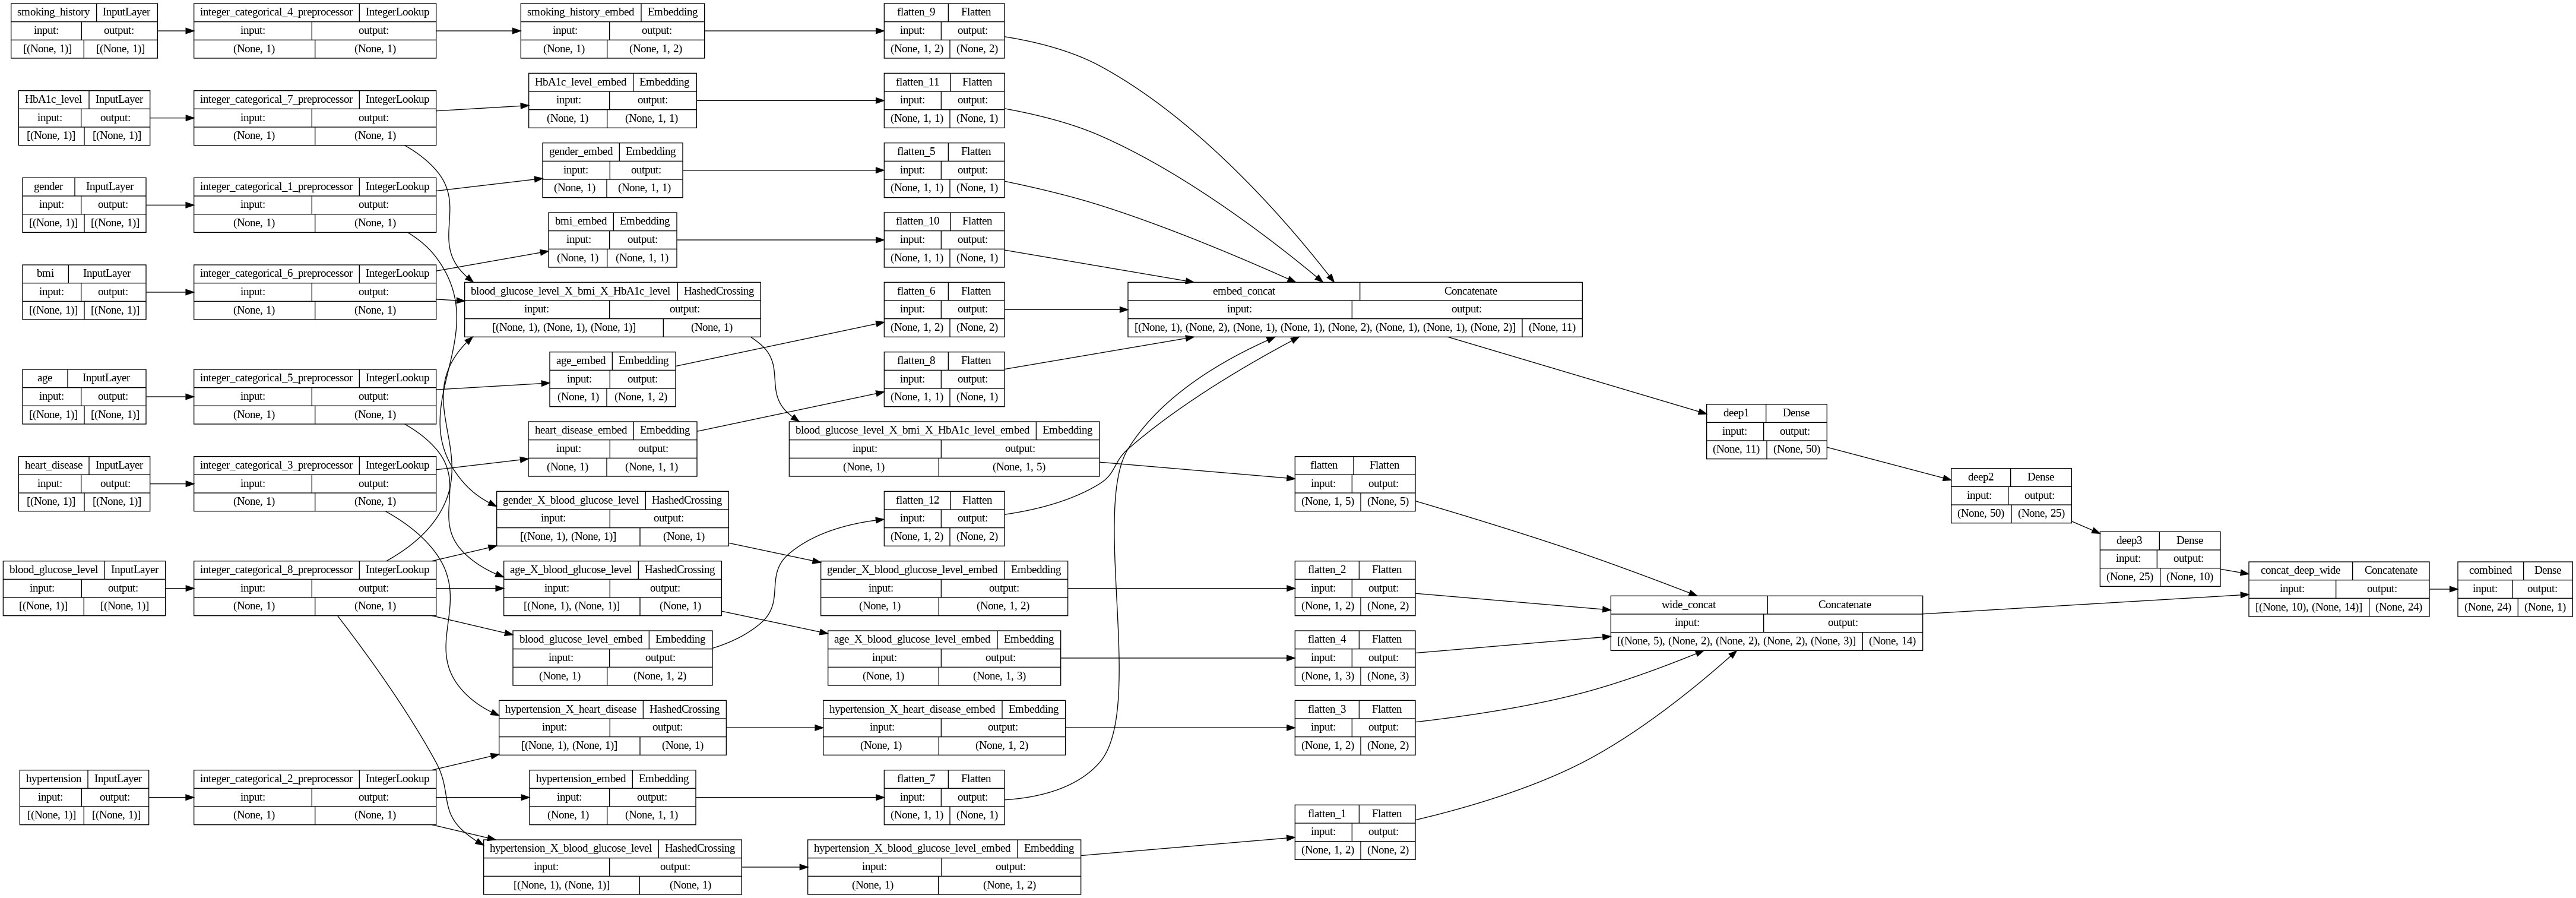

In [14]:
%%time
# time how long it takes this cell to run and output the time

# use unprocessed features here to gain access to each output
# retrieves input features for the model from the feature space
dict_inputs = feature_space.get_inputs()

# stores the output tensors from the embeddings of crossed features
crossed_outputs = []

# iterates over each crossed_feature defined in the feature space
# creates an embedding for each crossed feature defined in the feature space
# creates an embedding with setup_embedding_from_crossing
# stores the resulting tensor in crossed_outputs
for col in feature_space.crossers.keys():

    # x is a tensor
    x = setup_embedding_from_crossing(feature_space, col)

    # save outputs for concatenation later
    crossed_outputs.append(x)

# concatenate the embeddings of crossed layers into a single tensor
# this forms the wide part of the Neural Network, linear and aimed at memorizing sparse feature interactions
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# list to store the embeddings of categorical features
# these embeddings will form the deep part of the network, aimed at generalization through dense representations
all_deep_branch_outputs = []

# set up embeddings as before
# iterating over df_encoded this time (exclude the target variable diabetes with .drop and axis=1)
for col in df_encoded.drop(['diabetes'], axis=1).columns:

    # collects tensors after embedding
    x = setup_embedding_from_categorical(feature_space, col)

    # save for concatenation
    all_deep_branch_outputs.append(x)

# concatenates the categorical feature embeddings, forming the deep branch of the model input
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
# add several fully connected deep layers with relu activation
# name=... gives each layer a name for easy understanding later
# (deep_branch) applies the deep branch to the end
# units specifies the neurons (number of nodes) in the layer
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=25,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep3')(deep_branch)

# combine the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)
# constructs the KERAs model with inputs and outputs
training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)

# compiles the KERAs model with ADAM optimizer, mean-squared error loss, and a precision-at-recall metric for evaluation
training_model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=[tf.keras.metrics.PrecisionAtRecall(recall=precision_to_recall)]
)
# gives a summary of the model's architecture --- includes layers, shapes, and parameters
training_model.summary()

# generates and saves a graphical representation of the model -- shows the layers, thier shapes, and how they are connected
plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [15]:
# executes the training process for the neural network model
# has hyper parameters for epochs
history = training_model.fit(
    ds_train, epochs=num_epochs, validation_data=ds_test, verbose=2
)

Epoch 1/25
26/26 - 5s - loss: 0.2416 - precision_at_recall: 0.1123 - val_loss: 0.2254 - val_precision_at_recall: 0.1159 - 5s/epoch - 211ms/step
Epoch 2/25
26/26 - 1s - loss: 0.2069 - precision_at_recall: 0.1136 - val_loss: 0.1808 - val_precision_at_recall: 0.1124 - 684ms/epoch - 26ms/step
Epoch 3/25
26/26 - 1s - loss: 0.1503 - precision_at_recall: 0.1144 - val_loss: 0.1142 - val_precision_at_recall: 0.1182 - 701ms/epoch - 27ms/step
Epoch 4/25
26/26 - 1s - loss: 0.0988 - precision_at_recall: 0.1200 - val_loss: 0.0918 - val_precision_at_recall: 0.1305 - 726ms/epoch - 28ms/step
Epoch 5/25
26/26 - 1s - loss: 0.0900 - precision_at_recall: 0.1369 - val_loss: 0.0879 - val_precision_at_recall: 0.1669 - 687ms/epoch - 26ms/step
Epoch 6/25
26/26 - 1s - loss: 0.0851 - precision_at_recall: 0.1709 - val_loss: 0.0819 - val_precision_at_recall: 0.2005 - 726ms/epoch - 28ms/step
Epoch 7/25
26/26 - 1s - loss: 0.0768 - precision_at_recall: 0.2202 - val_loss: 0.0715 - val_precision_at_recall: 0.2301 - 679m

Text(0.5, 0, 'epochs')

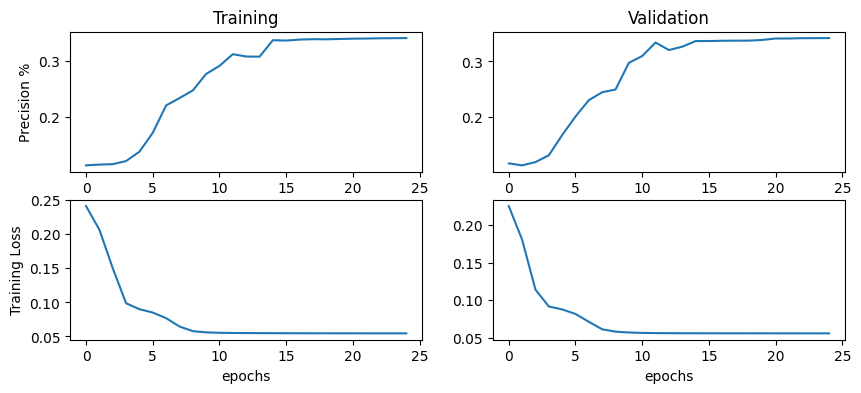

In [16]:
from matplotlib import pyplot as plt

%matplotlib inline

plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_at_recall'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_at_recall'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [17]:
# use the sklearn metrics
from sklearn import metrics as mt

y_test = tf.concat([y for x, y in ds_test], axis=0)
y_test = y_test.numpy()
y_test

# now lets see how well the model performed
yhat_proba = training_model.predict(ds_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions
yhat = np.round(yhat_proba.squeeze()) # round to get binary class

print(y_test[0])
print(yhat[0])

print(mt.confusion_matrix(y_test, yhat))
print(mt.classification_report(y_test, yhat))

7/7 [==============================] - 0s 20ms/step
0
0.0
[[11120   306]
 [  698   711]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     11426
           1       0.70      0.50      0.59      1409

    accuracy                           0.92     12835
   macro avg       0.82      0.74      0.77     12835
weighted avg       0.91      0.92      0.92     12835



_[2 points] Investigate generalization performance by altering the number of layers in the deep branch of the network. Try at least two models (this "two" includes the wide and deep model trained from the previous step). Use the method of cross validation and evaluation metric that you argued for at the beginning of the lab to answer: What model with what number of layers performs superiorly? Use proper statistical methods to compare the performance of different models._

### Add one layer and make the deep branch 4 layers

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 gender (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 hypertension (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 heart_disease (InputLayer)  [(None, 1)]                  0         []                            
                                                                                            

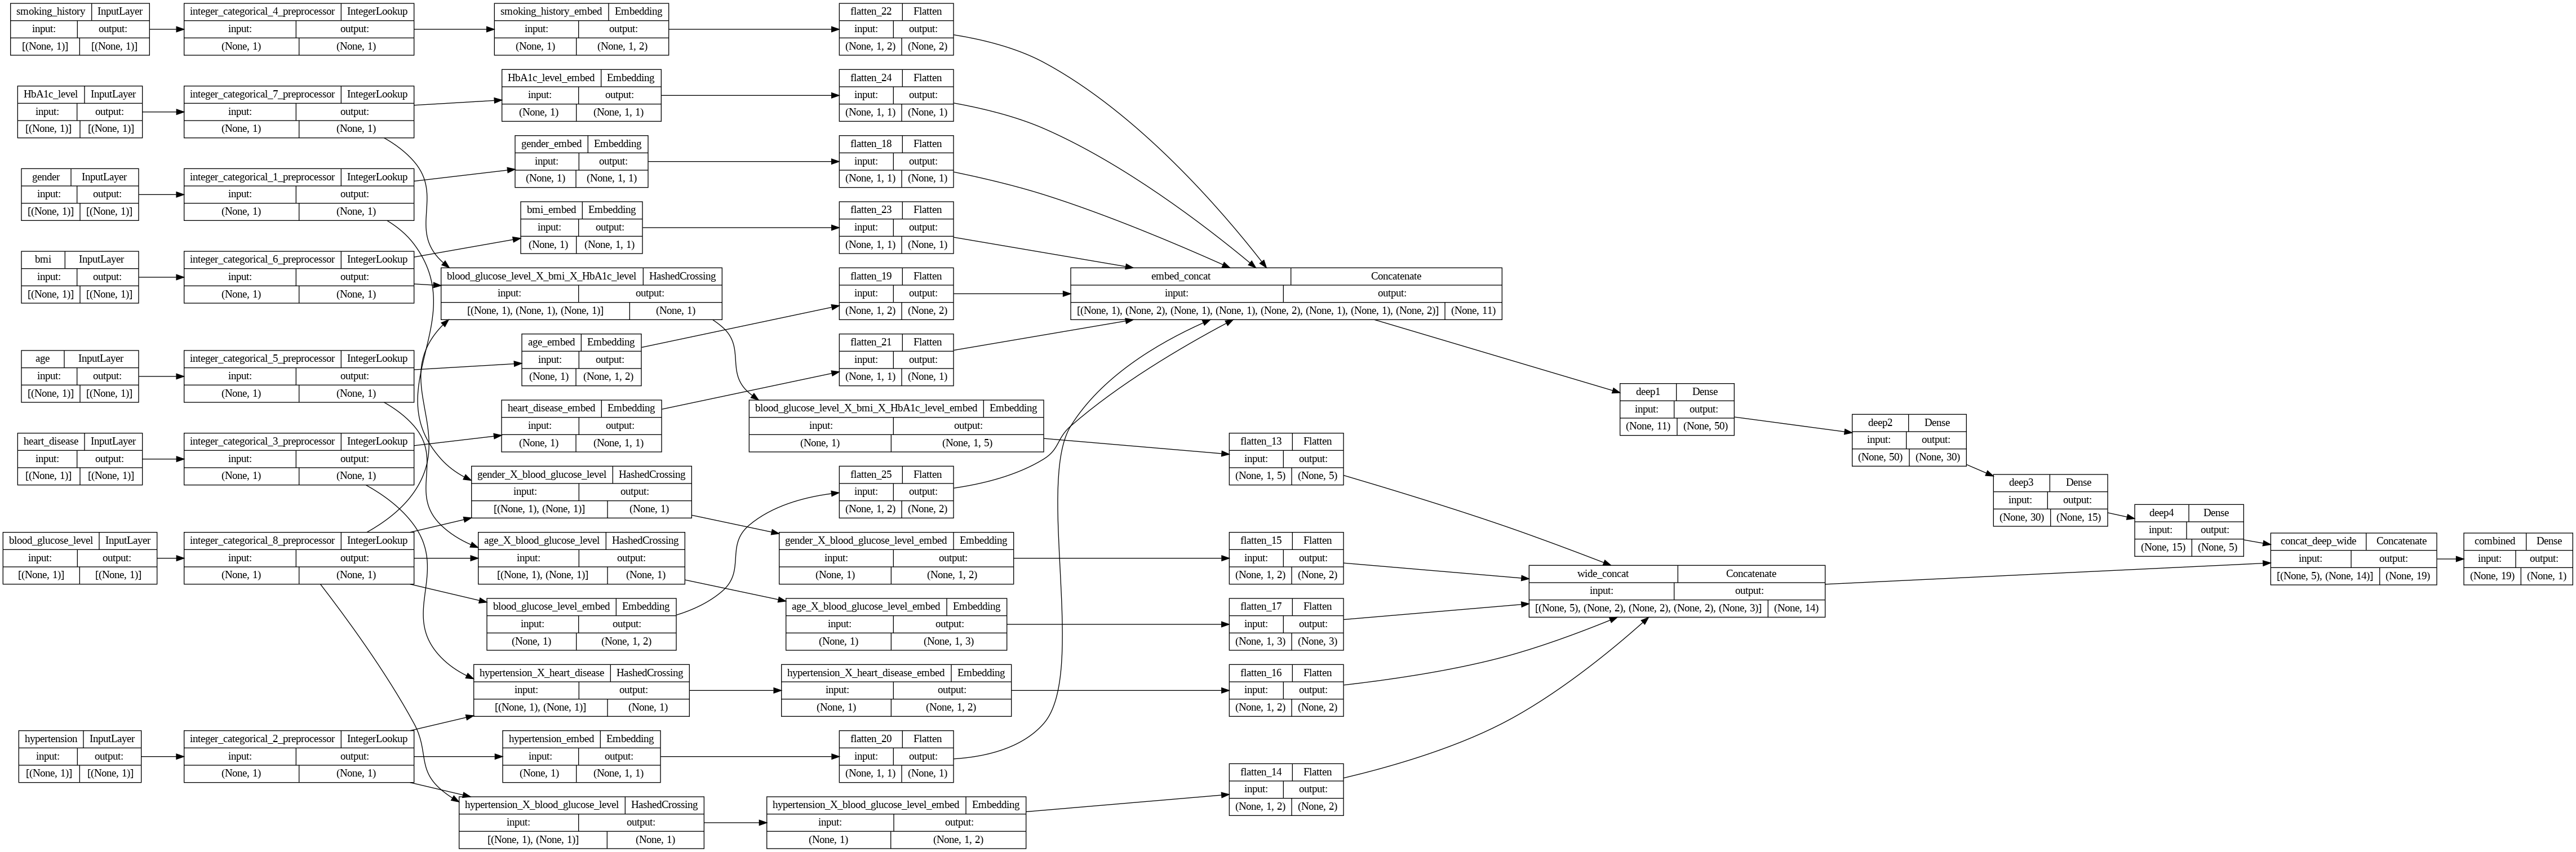

In [18]:
%%time

# need to use unprocessed features here, to gain access to each output
dict_inputs = feature_space.get_inputs()

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():

    x = setup_embedding_from_crossing(feature_space, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each categorical variable
for col in df_encoded.drop(['diabetes'], axis=1).columns:
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=30,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=15,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=5,activation='relu', name='deep4')(deep_branch)

# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=[tf.keras.metrics.PrecisionAtRecall(recall=precision_to_recall)]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [19]:
history = training_model.fit(
    ds_train, epochs=num_epochs, validation_data=ds_test, verbose=2
)

Epoch 1/25
26/26 - 5s - loss: 0.2285 - precision_at_recall_1: 0.1145 - val_loss: 0.1886 - val_precision_at_recall_1: 0.1257 - 5s/epoch - 190ms/step
Epoch 2/25
26/26 - 1s - loss: 0.1434 - precision_at_recall_1: 0.1168 - val_loss: 0.0995 - val_precision_at_recall_1: 0.1432 - 1s/epoch - 49ms/step
Epoch 3/25
26/26 - 1s - loss: 0.0914 - precision_at_recall_1: 0.1397 - val_loss: 0.0870 - val_precision_at_recall_1: 0.1812 - 744ms/epoch - 29ms/step
Epoch 4/25
26/26 - 1s - loss: 0.0810 - precision_at_recall_1: 0.1910 - val_loss: 0.0741 - val_precision_at_recall_1: 0.2181 - 700ms/epoch - 27ms/step
Epoch 5/25
26/26 - 1s - loss: 0.0679 - precision_at_recall_1: 0.2051 - val_loss: 0.0648 - val_precision_at_recall_1: 0.2433 - 740ms/epoch - 28ms/step
Epoch 6/25
26/26 - 1s - loss: 0.0610 - precision_at_recall_1: 0.2662 - val_loss: 0.0595 - val_precision_at_recall_1: 0.2871 - 705ms/epoch - 27ms/step
Epoch 7/25
26/26 - 1s - loss: 0.0570 - precision_at_recall_1: 0.2956 - val_loss: 0.0574 - val_precision_a

Text(0.5, 0, 'epochs')

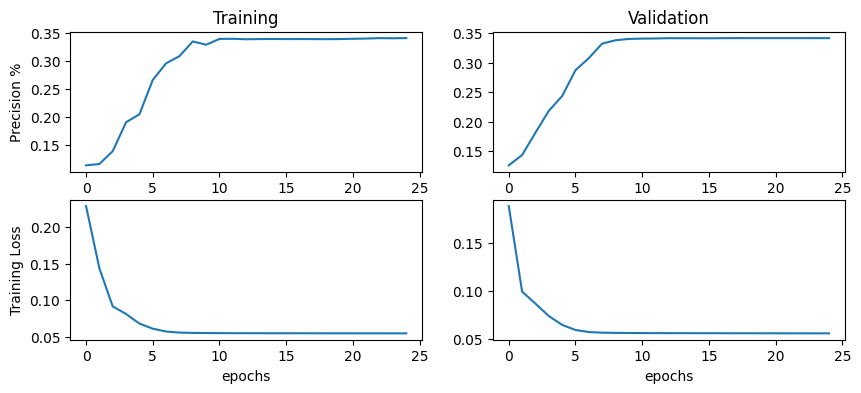

In [20]:
# plot the performance of the additional layer
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_at_recall_1'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_at_recall_1'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [21]:
# collect the performance of the additional layer
y_test = tf.concat([y for x, y in ds_test], axis=0)
y_test = y_test.numpy()
y_test

# now lets see how well the model performed
yhat_proba = training_model.predict(ds_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions
yhat = np.round(yhat_proba.squeeze()) # round to get binary class

print(mt.confusion_matrix(y_test, yhat))
print(mt.classification_report(y_test, yhat))

7/7 [==============================] - 0s 18ms/step
[[11121   305]
 [  697   712]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     11426
           1       0.70      0.51      0.59      1409

    accuracy                           0.92     12835
   macro avg       0.82      0.74      0.77     12835
weighted avg       0.91      0.92      0.92     12835



### Add one more layer to make the deep branch 5 layers

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 gender (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 hypertension (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 heart_disease (InputLayer)  [(None, 1)]                  0         []                            
                                                                                            

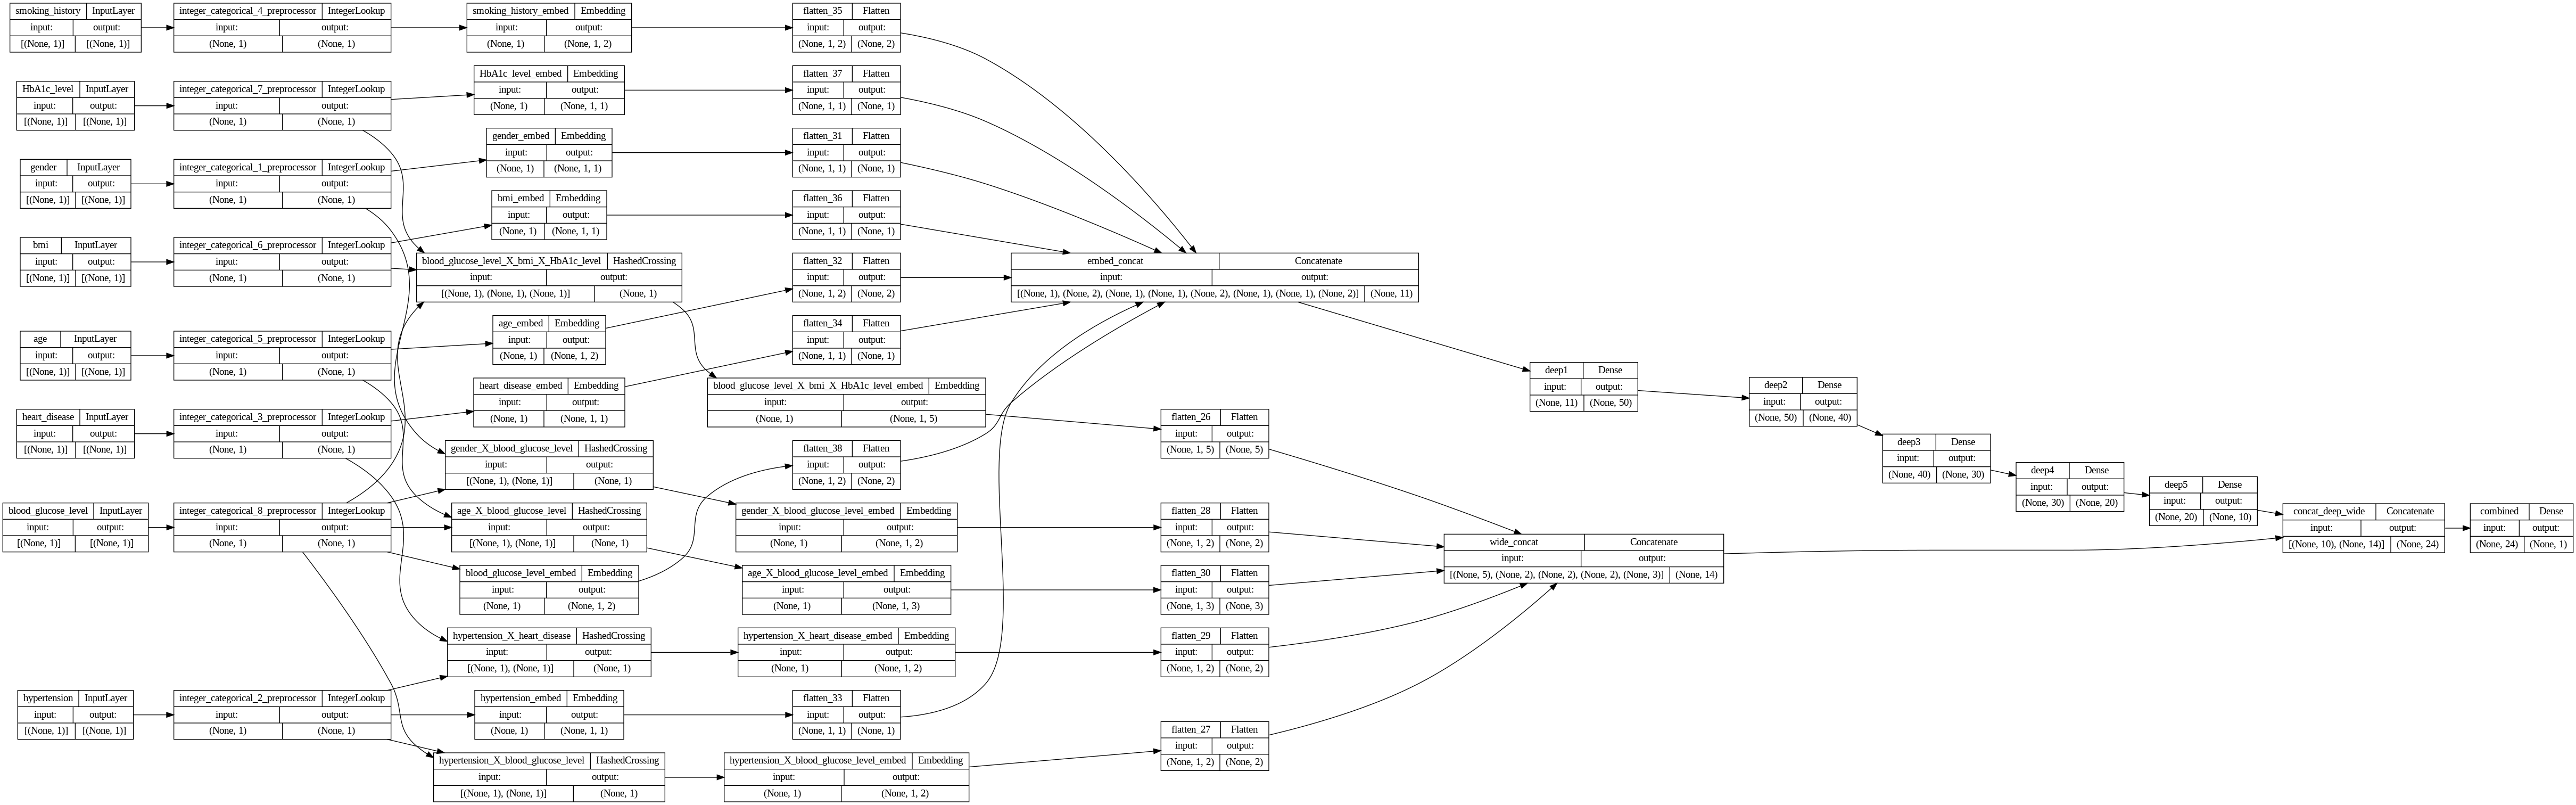

In [22]:
%%time

# need to use unprocessed features here, to gain access to each output
dict_inputs = feature_space.get_inputs()

# we need to create separate lists for each branch
crossed_outputs = []

# for each crossed variable, make an embedding
for col in feature_space.crossers.keys():

    x = setup_embedding_from_crossing(feature_space, col)

    # save these outputs in list to concatenate later
    crossed_outputs.append(x)

# now concatenate the outputs and add a fully connected layer
wide_branch = Concatenate(name='wide_concat')(crossed_outputs)

# reset this input branch
all_deep_branch_outputs = []

# for each categorical variable
for col in df_encoded.drop(['diabetes'], axis=1).columns:
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=40,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=30,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch)

# merge the deep and wide branch
final_branch = Concatenate(name='concat_deep_wide')([deep_branch, wide_branch])
final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(final_branch)

training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=[tf.keras.metrics.PrecisionAtRecall(recall=precision_to_recall)]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [23]:
history = training_model.fit(
    ds_train, epochs=num_epochs, validation_data=ds_test, verbose=2
)

Epoch 1/25
26/26 - 4s - loss: 0.2177 - precision_at_recall_2: 0.1118 - val_loss: 0.1684 - val_precision_at_recall_2: 0.1100 - 4s/epoch - 166ms/step
Epoch 2/25
26/26 - 1s - loss: 0.1199 - precision_at_recall_2: 0.1122 - val_loss: 0.0970 - val_precision_at_recall_2: 0.1228 - 1s/epoch - 41ms/step
Epoch 3/25
26/26 - 1s - loss: 0.0952 - precision_at_recall_2: 0.1282 - val_loss: 0.0919 - val_precision_at_recall_2: 0.2498 - 1s/epoch - 50ms/step
Epoch 4/25
26/26 - 2s - loss: 0.0876 - precision_at_recall_2: 0.2495 - val_loss: 0.0814 - val_precision_at_recall_2: 0.2698 - 2s/epoch - 87ms/step
Epoch 5/25
26/26 - 1s - loss: 0.0728 - precision_at_recall_2: 0.2965 - val_loss: 0.0645 - val_precision_at_recall_2: 0.3145 - 731ms/epoch - 28ms/step
Epoch 6/25
26/26 - 1s - loss: 0.0604 - precision_at_recall_2: 0.3127 - val_loss: 0.0594 - val_precision_at_recall_2: 0.3287 - 739ms/epoch - 28ms/step
Epoch 7/25
26/26 - 1s - loss: 0.0574 - precision_at_recall_2: 0.3282 - val_loss: 0.0577 - val_precision_at_reca

Text(0.5, 0, 'epochs')

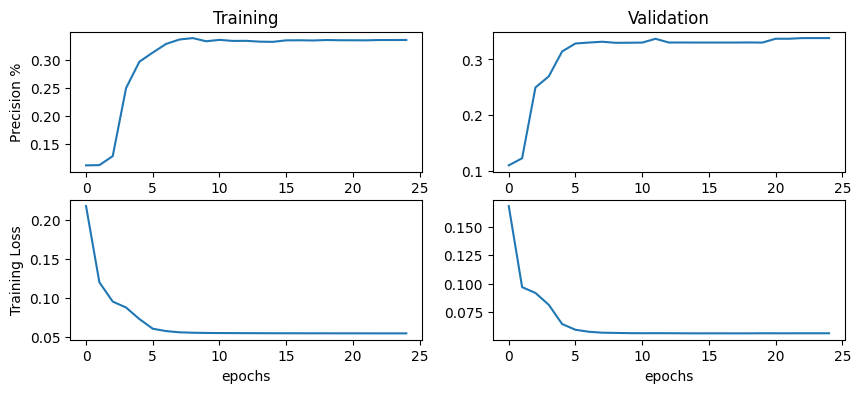

In [24]:
# plot the added layer
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_at_recall_2'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_at_recall_2'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [25]:
y_test = tf.concat([y for x, y in ds_test], axis=0)
y_test = y_test.numpy()
y_test

# now lets see how well the model performed
yhat_proba = training_model.predict(ds_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions
yhat = np.round(yhat_proba.squeeze()) # round to get binary class

print(mt.confusion_matrix(y_test, yhat))
print(mt.classification_report(y_test, yhat))

7/7 [==============================] - 1s 30ms/step
[[11108   318]
 [  691   718]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     11426
           1       0.69      0.51      0.59      1409

    accuracy                           0.92     12835
   macro avg       0.82      0.74      0.77     12835
weighted avg       0.91      0.92      0.92     12835



_[1 points] Compare the performance of your best wide and deep network to a standard multi-layer perceptron (MLP). Alternatively, you can compare to a network without the wide branch (i.e., just the deep network). For classification tasks, compare using the receiver operating characteristic and area under the curve. For regression tasks, use Bland-Altman plots and residual variance calculations.  Use proper statistical methods to compare the performance of different models._

### Network without the wide branch

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 gender (InputLayer)         [(None, 1)]                  0         []                            
                                                                                                  
 age (InputLayer)            [(None, 1)]                  0         []                            
                                                                                                  
 hypertension (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 heart_disease (InputLayer)  [(None, 1)]                  0         []                            
                                                                                            

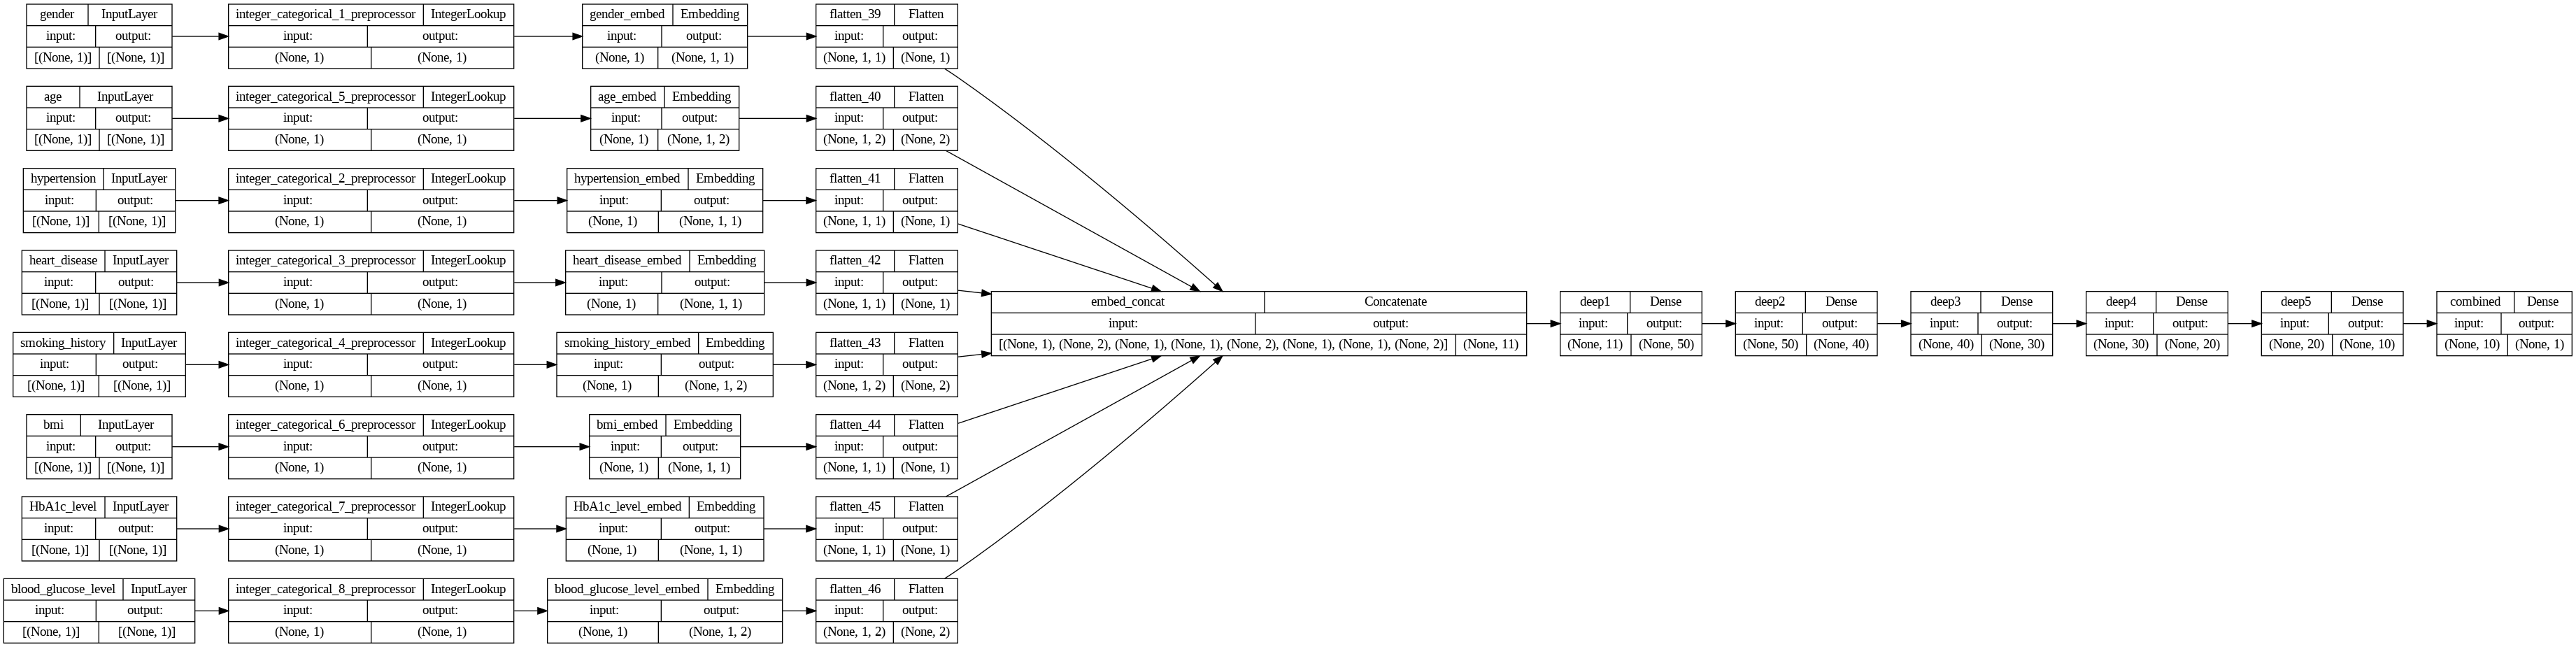

In [26]:
%%time

# need to use unprocessed features here, to gain access to each output
dict_inputs = feature_space.get_inputs()

# reset this input branch
all_deep_branch_outputs = []

# for each categorical variable
for col in df_encoded.drop(['diabetes'], axis=1).columns:
    # get the output tensor from ebedding layer
    x = setup_embedding_from_categorical(feature_space, col)

    # save these outputs in list to concatenate later
    all_deep_branch_outputs.append(x)

# merge the deep branches together
deep_branch = Concatenate(name='embed_concat')(all_deep_branch_outputs)
deep_branch = Dense(units=50,activation='relu', name='deep1')(deep_branch)
deep_branch = Dense(units=40,activation='relu', name='deep2')(deep_branch)
deep_branch = Dense(units=30,activation='relu', name='deep3')(deep_branch)
deep_branch = Dense(units=20,activation='relu', name='deep4')(deep_branch)
deep_branch = Dense(units=10,activation='relu', name='deep5')(deep_branch)

final_branch = Dense(units=1,activation='sigmoid',
                     name='combined')(deep_branch)

training_model = keras.Model(inputs=dict_inputs, outputs=final_branch)
training_model.compile(
    optimizer="adam", loss="mean_squared_error", metrics=[tf.keras.metrics.PrecisionAtRecall(recall=precision_to_recall)]
)

training_model.summary()

plot_model(
    training_model, to_file='model.png', show_shapes=True, show_layer_names=True,
    rankdir='LR', expand_nested=False, dpi=96
)

In [27]:
history = training_model.fit(
    ds_train, epochs=num_epochs, validation_data=ds_test, verbose=2
)

Epoch 1/25
26/26 - 4s - loss: 0.2075 - precision_at_recall_3: 0.1110 - val_loss: 0.1392 - val_precision_at_recall_3: 0.1277 - 4s/epoch - 136ms/step
Epoch 2/25
26/26 - 1s - loss: 0.1055 - precision_at_recall_3: 0.1181 - val_loss: 0.0973 - val_precision_at_recall_3: 0.1509 - 621ms/epoch - 24ms/step
Epoch 3/25
26/26 - 1s - loss: 0.0938 - precision_at_recall_3: 0.1226 - val_loss: 0.0904 - val_precision_at_recall_3: 0.1656 - 617ms/epoch - 24ms/step
Epoch 4/25
26/26 - 1s - loss: 0.0851 - precision_at_recall_3: 0.2115 - val_loss: 0.0780 - val_precision_at_recall_3: 0.2100 - 634ms/epoch - 24ms/step
Epoch 5/25
26/26 - 1s - loss: 0.0709 - precision_at_recall_3: 0.2301 - val_loss: 0.0669 - val_precision_at_recall_3: 0.2307 - 605ms/epoch - 23ms/step
Epoch 6/25
26/26 - 1s - loss: 0.0636 - precision_at_recall_3: 0.2713 - val_loss: 0.0620 - val_precision_at_recall_3: 0.2761 - 629ms/epoch - 24ms/step
Epoch 7/25
26/26 - 1s - loss: 0.0610 - precision_at_recall_3: 0.3218 - val_loss: 0.0613 - val_precisio

Text(0.5, 0, 'epochs')

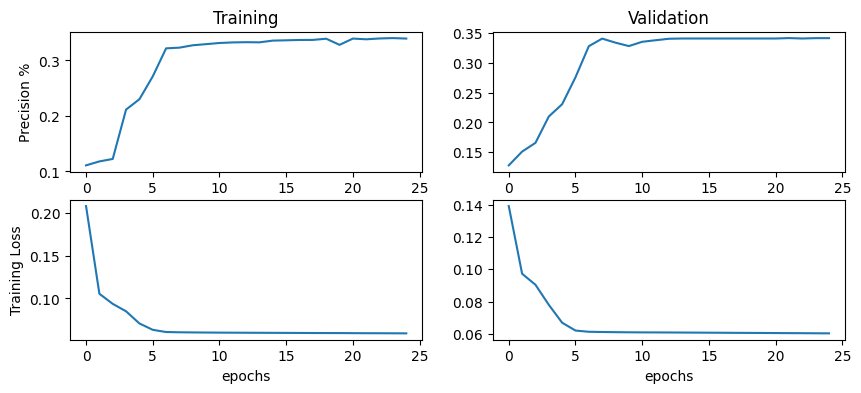

In [28]:
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['precision_at_recall_3'])

plt.ylabel('Precision %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_precision_at_recall_3'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')

In [29]:
y_test = tf.concat([y for x, y in ds_test], axis=0)
y_test = y_test.numpy()
y_test

# now lets see how well the model performed
yhat_proba = training_model.predict(ds_test) # sigmoid output probabilities
# use squeeze to get rid of any extra dimensions
yhat = np.round(yhat_proba.squeeze()) # round to get binary class

print(mt.confusion_matrix(y_test, yhat))
print(mt.classification_report(y_test, yhat))

7/7 [==============================] - 0s 24ms/step
[[11120   306]
 [  698   711]]
              precision    recall  f1-score   support

           0       0.94      0.97      0.96     11426
           1       0.70      0.50      0.59      1409

    accuracy                           0.92     12835
   macro avg       0.82      0.74      0.77     12835
weighted avg       0.91      0.92      0.92     12835



# Exceptional Work

_One idea (required for 7000 level students): Capture the embedding weights from the deep network and (if needed) perform dimensionality reduction on the output of these embedding layers (only if needed). That is, pass the observations into the network, save the embedded weights (called embeddings), and then perform  dimensionality reduction in order to visualize results. Visualize and explain any clusters in the data._

"we decided to try the 7000 level even though we are 5000 level, if our approach is not good do not take points off" - Alex Chen

In [30]:
# list all layer names in the model
layer_names = [layer.name for layer in training_model.layers]

# filter out the names that end with '_embed', which are the embedding layers
embedding_layer_names = [name for name in layer_names if name.endswith('_embed')]

# print the names of the embedding layers
print("Embedding layer names:")
for name in embedding_layer_names:
    print(name)


Embedding layer names:
gender_embed
age_embed
hypertension_embed
heart_disease_embed
smoking_history_embed
bmi_embed
HbA1c_level_embed
blood_glucose_level_embed


In [31]:
# output embeddings for all identified layers

from tensorflow.keras.models import Model

# create a new model that outputs embeddings from all embedding layers
embedding_layer_outputs = [training_model.get_layer(name).output for name in embedding_layer_names]
embedding_model = Model(inputs=training_model.input, outputs=embedding_layer_outputs)


In [32]:
# generate the embeddings

# using ds_train as model input
embeddings = embedding_model.predict(ds_train)


26/26 [==============================] - 1s 28ms/step


In [33]:
# understand the shape of embeddings


# inspect the shape of each set of embeddings
for idx, emb in enumerate(embeddings):
    print(f"Shape of embeddings from {embedding_layer_names[idx]}: {emb.shape}")


Shape of embeddings from gender_embed: (51337, 1, 1)
Shape of embeddings from age_embed: (51337, 1, 2)
Shape of embeddings from hypertension_embed: (51337, 1, 1)
Shape of embeddings from heart_disease_embed: (51337, 1, 1)
Shape of embeddings from smoking_history_embed: (51337, 1, 2)
Shape of embeddings from bmi_embed: (51337, 1, 1)
Shape of embeddings from HbA1c_level_embed: (51337, 1, 1)
Shape of embeddings from blood_glucose_level_embed: (51337, 1, 2)


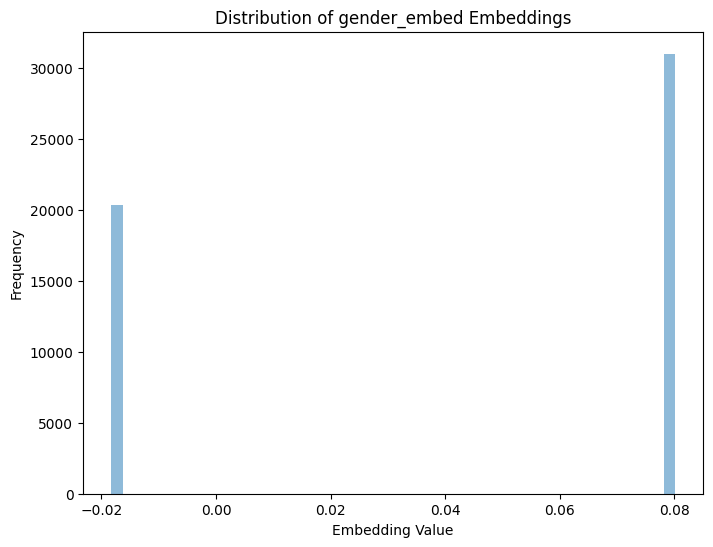

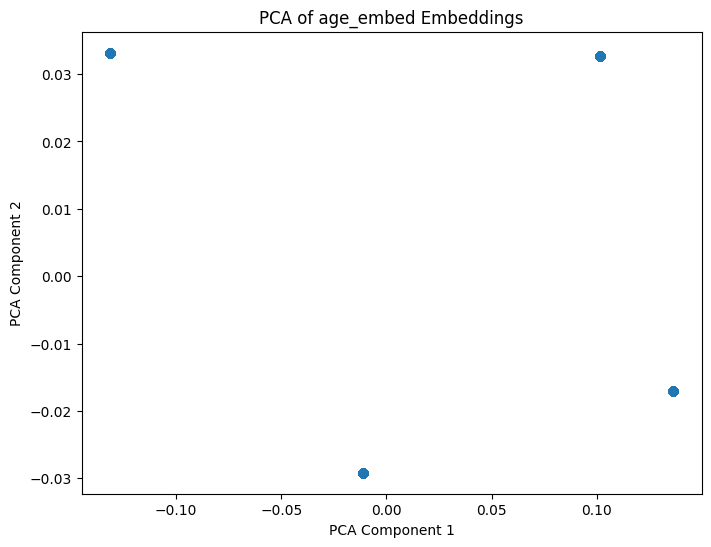

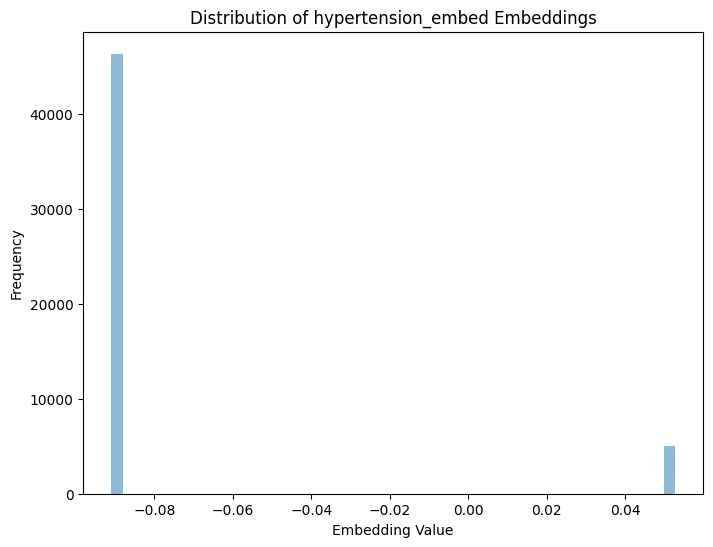

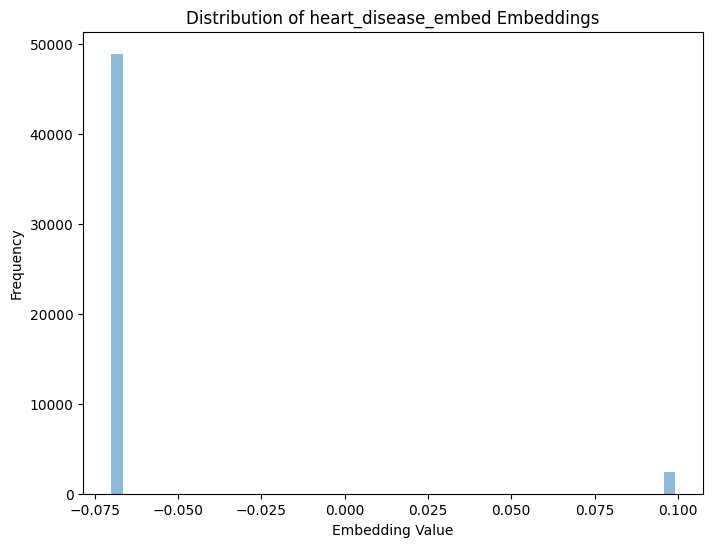

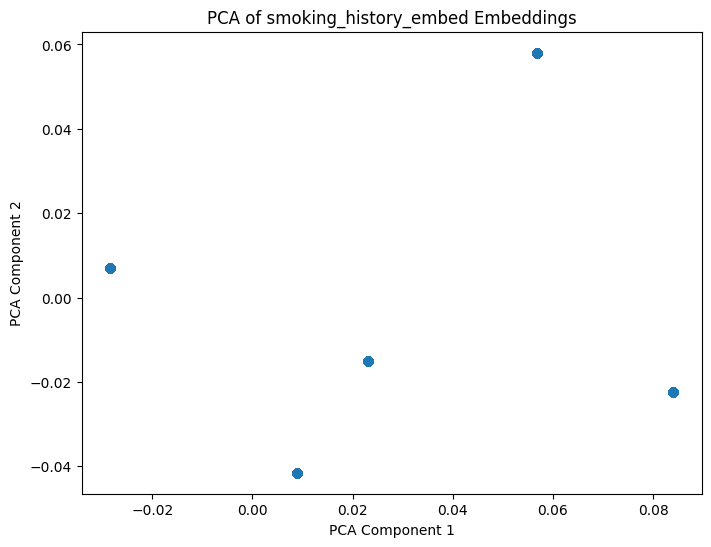

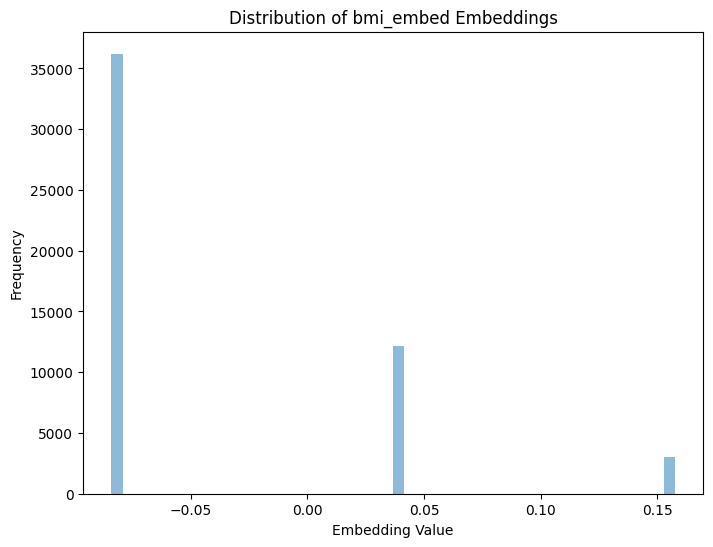

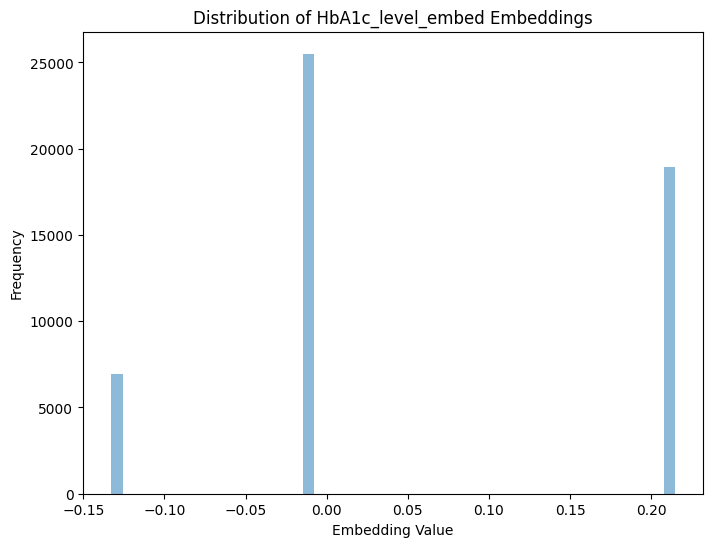

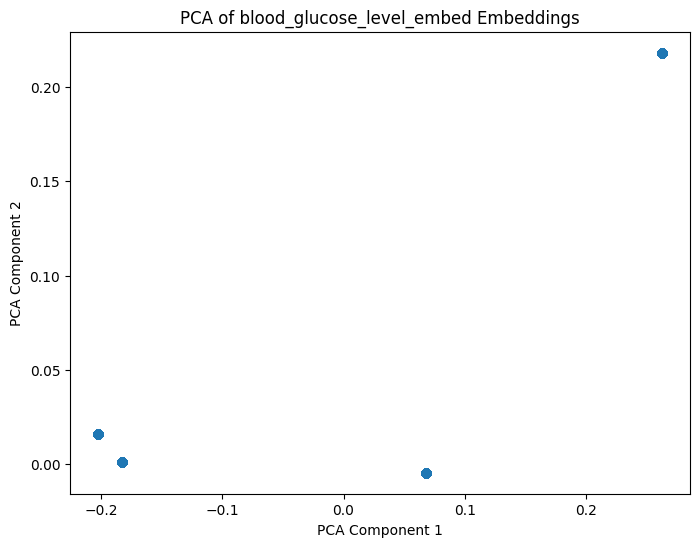

In [34]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

for idx, emb in enumerate(embeddings):
    emb = emb.reshape(emb.shape[0], -1)  # flatten the embeddings

    # check if embeddings are already 1-dimensional
    if emb.shape[1] == 1:
        # for 1-dimensional embeddings, directly plot their distribution
        plt.figure(figsize=(8, 6))
        plt.hist(emb, bins=50, alpha=0.5)
        plt.title(f"Distribution of {embedding_layer_names[idx]} Embeddings")
        plt.xlabel("Embedding Value")
        plt.ylabel("Frequency")
    else:
        # apply PCA to reduce to 2 dimensions for visualization
        pca = PCA(n_components=2)
        reduced_emb = pca.fit_transform(emb)

        # visualization for multi-dimensional embeddings
        plt.figure(figsize=(8, 6))
        plt.scatter(reduced_emb[:, 0], reduced_emb[:, 1], alpha=0.5)
        plt.title(f"PCA of {embedding_layer_names[idx]} Embeddings")
        plt.xlabel("PCA Component 1")
        plt.ylabel("PCA Component 2")

    plt.show()


These histograms show the distribution of the embeddings. This shows how our model's embeddings distinguish between our categorical features. Features with narrow embedding distributions show that the model may not get a lot of information. A narrow distribution where data points concentrate around specific embedding values might suggest that the model does not differentiate much within that feature. This could be from a feature that lacks diverse data or the feature may not be significant to the model's predictions. Wider distributions in PCA space suggest a deeper understanding of the data.
